In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset
from torchvision import transforms, models
from torchvision.utils import make_grid
import cv2
from PIL import Image

import os
import time

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (30,30)

os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"

In [2]:
class MultiscaleDataset(Dataset):
    def __init__(self, root, transform, LR_scale=2, HR_size=[224,224], interpolate= True):               
        self.image_list = []
        self.LR_scale = LR_scale
        
        self.transform = transform
        
        if interpolate:
            self.LR_transform = transforms.Compose([
                transforms.Resize(HR_size[0]//LR_scale),
                transforms.Resize(HR_size)
            ])
        else:
            self.LR_transform = transforms.Resize(HR_size[0]//LR_scale)

        self.ToTensor = transforms.ToTensor()
        
        class_dirs = os.listdir(root)
        
        for label, class_dir in enumerate(class_dirs):
            image_dirs = os.listdir(os.path.join(root,class_dir))
            for img_path in image_dirs:
                self.image_list.append([label, os.path.join(root, class_dir, img_path)])
                
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        label = self.image_list[index][0]
        img = Image.open(self.image_list[index][1])
        
        img_modified = self.transform(img)
        
        HR = self.ToTensor(img_modified)
        LR = self.ToTensor(self.LR_transform(img_modified))
        
        # Exception handling for the grayscale images.
        if(HR.shape[0] == 1):
            HR = HR.repeat(3, 1, 1)
        if(LR.shape[0] == 1):
            LR = LR.repeat(3, 1, 1)
        #----------------------------------------------
        
        return LR, HR, label
    
def get_train_loader(root='/data/ILSVRC_Birds/train/', LR_scale=2, HR_size=[224,224], batch_size=128, num_workers=8, interpolate=True):
    transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
    ])

    train_dataset = MultiscaleDataset(root, transform=transform, LR_scale=LR_scale, HR_size=HR_size, interpolate=interpolate)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    return train_dataloader

def get_test_loader(root='/data/ILSVRC_Birds/val/', LR_scale=2, HR_size=[224,224], batch_size=128, num_workers=8, interpolate=True):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
    ])
    
    test_dataset = MultiscaleDataset(root, transform=transform, LR_scale=LR_scale, HR_size=HR_size, interpolate=interpolate)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    return test_dataloader

LR_scale = 4
train_loader = get_train_loader(LR_scale=LR_scale, batch_size=1, num_workers=8, interpolate=True)
test_loader = get_test_loader(LR_scale=LR_scale, batch_size=1, num_workers=8, interpolate=True)

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224]) torch.Size([1])


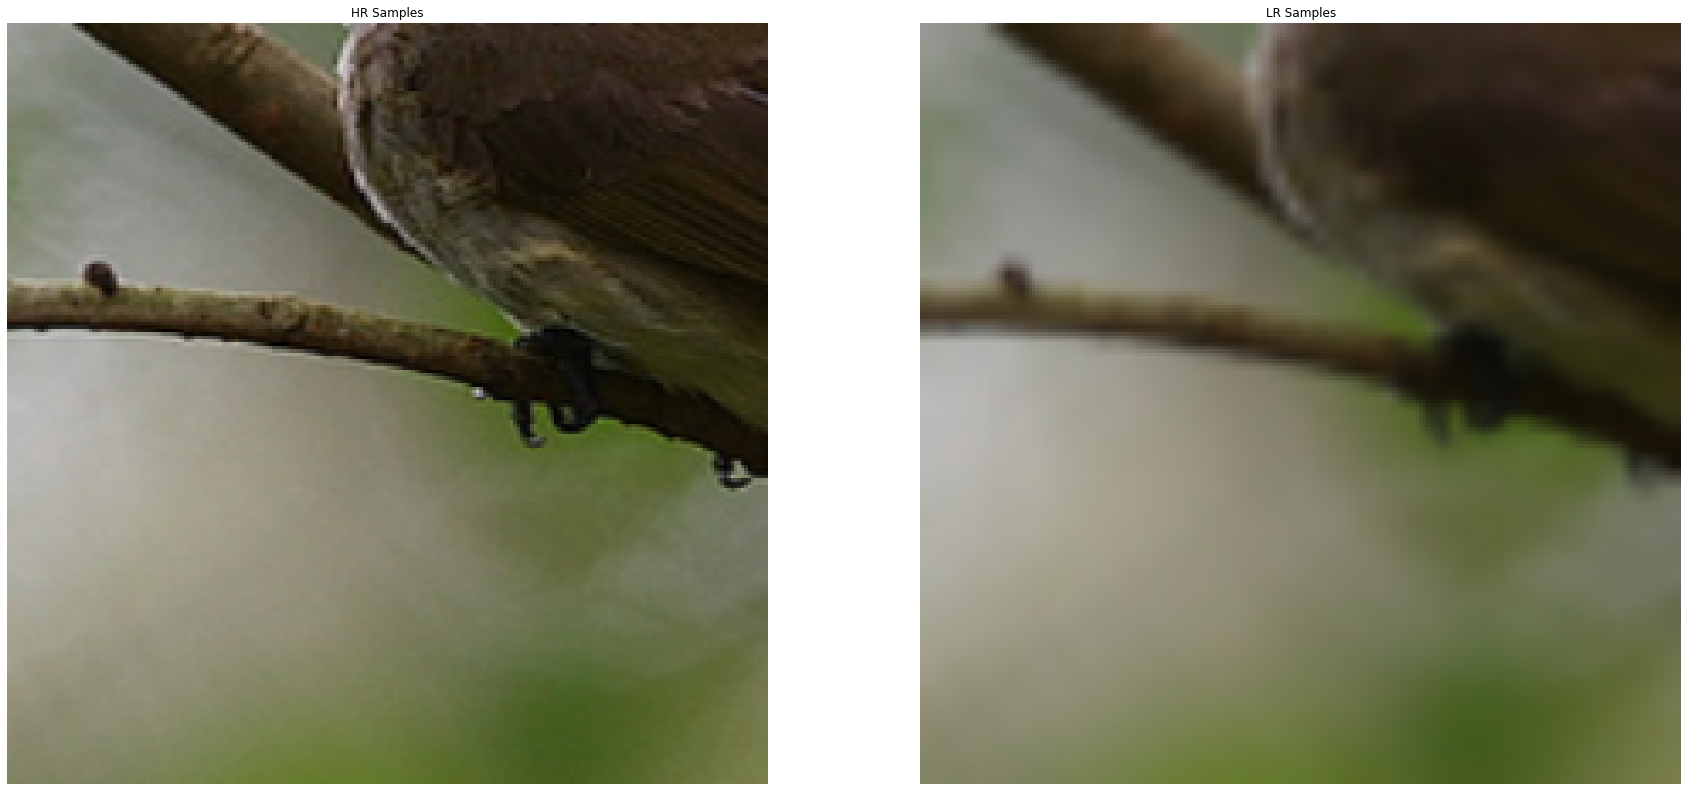

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224]) torch.Size([1])


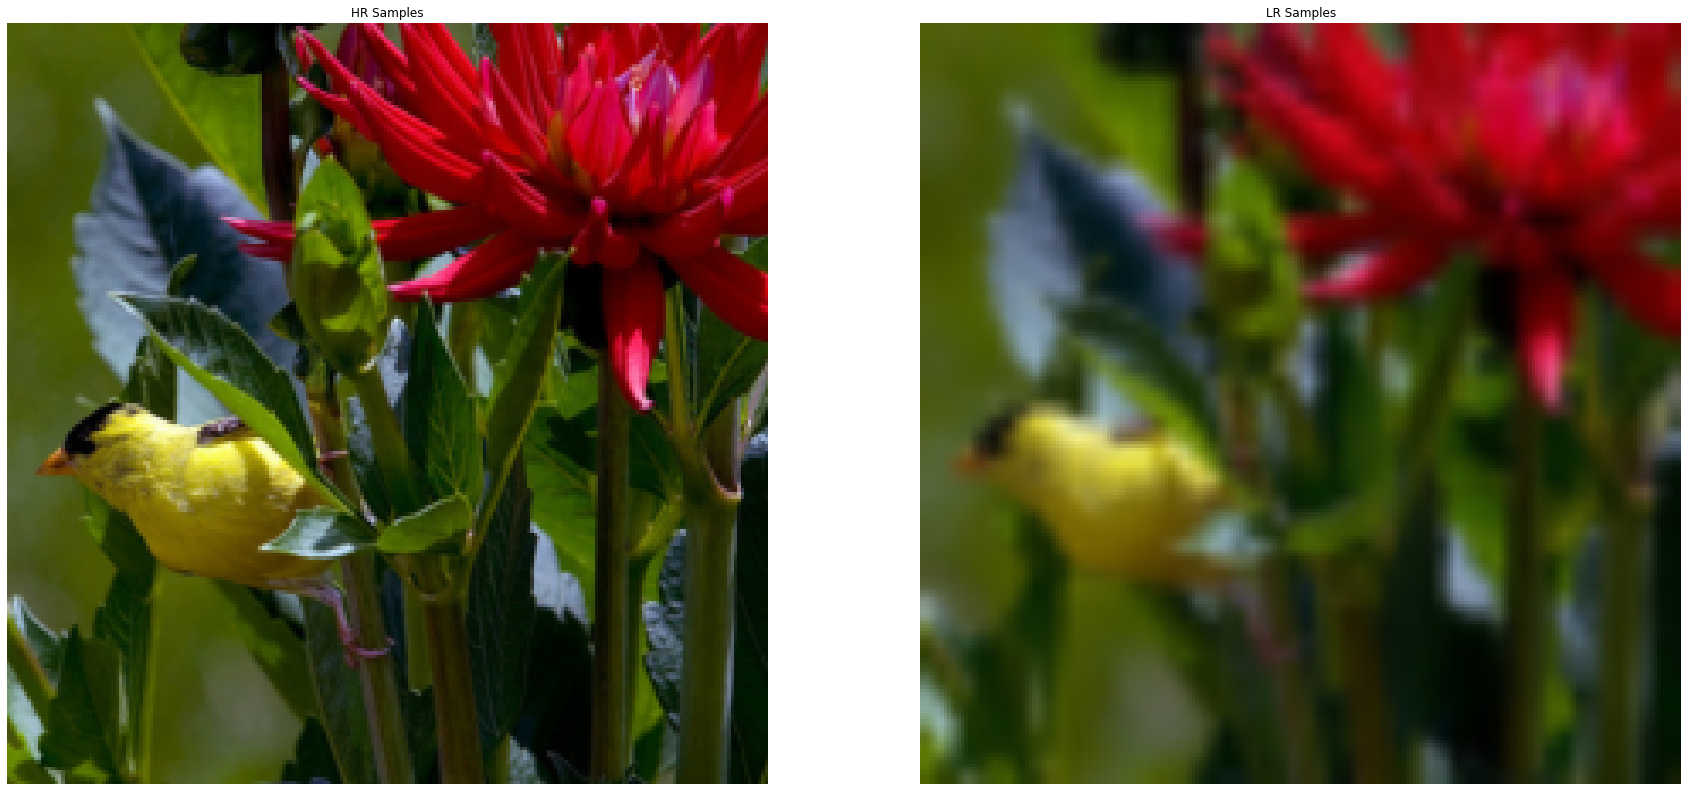

In [3]:
for data in train_loader:
    LR, HR, label = data[0], data[1], data[2]
    print(HR.shape, LR.shape, label.shape)
    
    fig, ax = plt.subplots(1,2)
    
    LR_samples = make_grid(LR, nrow=8).permute(1,2,0)
    HR_samples = make_grid(HR, nrow=8).permute(1,2,0)
    ax[0].imshow(HR_samples)
    ax[0].axis('off')
    ax[0].set_title('HR Samples')
    ax[1].imshow(LR_samples)
    ax[1].axis('off')
    ax[1].set_title('LR Samples')
    plt.show()
    break
    
for data in test_loader:
    LR, HR, label = data[0], data[1], data[2]
    print(HR.shape, LR.shape, label.shape)
    
    fig, ax = plt.subplots(1,2)
    
    LR_samples = make_grid(LR, nrow=8).permute(1,2,0)
    HR_samples = make_grid(HR, nrow=8).permute(1,2,0)
    ax[0].imshow(HR_samples)
    ax[0].axis('off')
    ax[0].set_title('HR Samples')
    ax[1].imshow(LR_samples)
    ax[1].axis('off')
    ax[1].set_title('LR Samples')
    plt.show()
    break

In [4]:
def get_model(model, pretrained=False, num_classes = 18):
    if model == 'resnet50':
        net = models.resnet50(pretrained=pretrained)
        net.fc = nn.Linear(in_features=2048, out_features=num_classes)
    elif model == 'resnet34':
        net = models.resnet34(pretrained=pretrained)
        net.fc = nn.Linear(in_features=512, out_features=num_classes)
    elif model == 'resnet18':
        net = models.resnet18(pretrained=pretrained)
        net.fc = nn.Linear(in_features=512, out_features=num_classes)
    return net

In [5]:
class HookWrapper(nn.Module):
    '''
        Wrapper class for Forward/Backward feature map extraction.

        - Usage -
        1) Make the instance of this class with the model and target layers.
        2) Forward/Backward it.
        3) Call get_features() will return the feature maps of previously forward/backwarded input.
        4) Back to 2).
    '''
    def __init__(self, model, target_layers):
        super(HookWrapper,self).__init__()
        self.model = model
        self.target_layers = target_layers
        self.features = [] # Size will be 4 after hook

        for name, module in model.named_children():
            if name in target_layers:
                module.register_forward_hook(self._extraction_fn)

    def _extraction_fn(self, module, input, output):
        # print(f"Test : {output.shape}")
        self.features.append(output)

    def forward(self, x):
        return self.model(x)
    
    def get_features(self): # Return feature list and make it empty.
        tmp = self.features
        self.features = []
        return tmp

target_layers = ['layer4']

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_name = "birds"

teacher_name = 'resnet18'
student_name = 'resnet18'
print(f"Teacher: {teacher_name}, Student: {student_name}")

net_t = get_model(teacher_name, pretrained=True, num_classes=18)
net_t = net_t.to(device)

net_s = get_model(student_name, pretrained=False, num_classes=18)
net_s = net_s.to(device)

hook_net_t = HookWrapper(net_t, target_layers)
hook_net_s = HookWrapper(net_s, target_layers)

Teacher: resnet18, Student: resnet18


UnboundLocalError: local variable 'net' referenced before assignment

In [7]:
# For multiple GPU support
hook_net_t = nn.DataParallel(hook_net_t)
hook_net_s = nn.DataParallel(hook_net_s)

NameError: name 'hook_net_t' is not defined

# New loss function between LR and HR representation
1. Fitting the feature map size 
    - Teacher(1x) : 224 -> (MaxPool) -> 112 -> 56 -> 28 -> 14 -> 7 GAP
    - Student (Smaller ResNets)
        - Ch  : 3   -> 64  -> 64  -> 128 -> 256 -> 512 
        - 2x  : 112 -> 112 -> 56  -> 28  -> 14  -> 7   -> GAP
        - 4x  : 56  -> 56  -> 28  -> 14  -> 7   -> 7   -> GAP
        - 8x  : 28  -> 28  -> 14  -> 14  -> 7   -> 7   -> GAP

In [8]:
class FusionModule(nn.Module):
    '''
        Implementation of Fusion Module

        - Concatenates two feature maps and fuse their features through depthwise separable convolution.
        - The final FC puts predictions with 'batch_size x num_classes' size.
        
    '''
    def __init__(self, in_channel,out_channel, num_classes):
        super(FusionModule, self).__init__()

        # in_channel = n_channel(f_t) + n_channel(f_s)

        self.conv_dw = nn.Conv2d(in_channel, in_channel, kernel_size=3,
                    padding=1, stride=1, groups=in_channel)
        self.conv_pw = nn.Conv2d(in_channel, out_channel, kernel_size=1,
                    padding=1, stride=1)

        self.activation = nn.ReLU()
        self.pooling = nn.AvgPool2d([7, 7])
        
        self.bn1 = nn.BatchNorm2d(in_channel)
        self.bn2 = nn.BatchNorm2d(out_channel)

        self.fc = nn.Linear(512, num_classes)

    def forward(self, f_t, f_s):
        
        # Assume that f_t and f_s have same spatial size.
        # If different? -> Try to learn representation of f_s -> f_t mapping. (LR-HR Problem)

        f_cat = torch.cat((f_t, f_s), dim=1) # dim=1 as channel dimension

        f_dw = self.activation(self.bn1(self.conv_dw(f_cat))) # DWConv -> BN -> ReLU
        f_pw = self.activation(self.bn2(self.conv_pw(f_dw)))  # PWConv -> BN -> ReLU

        f_pool = self.pooling(f_pw).flatten(1) # BS x n_classes 

        pred = self.fc(f_pool)

        return pred

net_f = FusionModule(1024, 512, num_classes=18).to(device)

# -- Test code for FusionModule --

# x = torch.randn([1,3,224,224]).to(device)

# y_t = hook_net_t(x)
# y_s = hook_net_s(x)

# ft_t = hook_net_t.module.get_features()
# ft_s = hook_net_s.module.get_features()

# print(y_t.shape, y_s.shape)
# print(ft_t[0].shape, ft_s[0].shape)

# y_fused = net_f(ft_t[0], ft_s[0])

# print(y_fused.shape)

In [9]:
class KD_loss():
    def __init__(self, params):
        self.fn = nn.KLDivLoss()
        self.alpha = params['alpha']
        self.T = params['T']
    def __call__(self, student_outputs, teacher_outputs):
        KD_loss = nn.KLDivLoss()(F.softmax(student_outputs/self.T, dim=1),
                             F.softmax(teacher_outputs/self.T, dim=1))
        return KD_loss

def fused_training(teacher, student, fusion, train_loader):
    params = {'alpha':0.9, 'T':20, 'beta':0.3}

    # According to 'Low-resolution visual recognition via deep feature distillation(DFD)',
    # They use MSE Loss for distillation loss instead of NLL loss.

    soft_criterion = KD_loss(params)
    hard_criterion = nn.CrossEntropyLoss()
    
    # DFD uses SGD with momentum 0.9, weight deacy 5e-4.
    optimizer = optim.SGD(student.parameters(),lr=1e-2, momentum=0.9, weight_decay=5e-4)
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, 50, gamma=0.1)
    
    train_avg_loss = 0
    n_count = 0
    n_corrects = 0

    teacher.train()
    student.train()
    fusion.train()

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        batch_lr, batch_hr, label = data[0].to(device), data[1].to(device), data[2].to(device) 

        pred_t = teacher(batch_hr)
        pred_s = student(batch_lr)

        # Acquire hard losses of the T/S.
        loss_t = hard_criterion(pred_t, label)
        loss_s = hard_criterion(pred_s, label)
        
        # Acquire fusion loss
        feature_t = teacher.module.get_features()[0]
        feature_s = student.module.get_features()[0]

        pred_f = fusion(feature_t, feature_s)
        loss_f = hard_criterion(pred_f, label)  

        # Acquire Ensemble-Fusion distillation loss
        pred_ens = (1/2)*(pred_t + pred_s)
        loss_kd_e = soft_criterion(pred_f, pred_ens)

        # Acquire Fusion-T/S distillation loss    
        loss_kd_t = soft_criterion(pred_f, pred_t)
        loss_kd_s = soft_criterion(pred_f, pred_s)
        loss_kd_f = loss_kd_t + loss_kd_s

        # Define total loss
        # print(loss_t.item(), loss_s.item(), loss_f.item(), loss_kd_e.item(), loss_kd_f.item())
        loss = loss_t + loss_s + loss_f + params['T']*params['T']*(loss_kd_e + loss_kd_f)

        train_avg_loss += loss

        n_corrects += torch.sum(torch.argmax(pred_s, dim=1) == label).item()
        n_count += label.shape[0]

        loss.backward()
        optimizer.step()
        
        if(i == len(train_loader)-1):
            print(f"loss = {loss:.4f}")

    train_accuracy = n_corrects/n_count
    train_avg_loss /= n_count

    return train_accuracy, train_avg_loss, student

In [10]:
def evaluate(teacher, student, test_loader, eval_target='LR'):
    teacher.eval()
    student.eval()
    
    n_count = 0
    n_corrects_t = 0
    n_corrects_s = 0
    
    if eval_target=='LR':
        target = 0
    else:
        target = 1

    for j, data in enumerate(test_loader):
        batch, label = data[target].to(device), data[2].to(device)

        pred_t = teacher(batch)
        pred_s = student(batch)
        n_corrects_t += torch.sum(torch.argmax(pred_t, dim=1) == label).item()
        n_corrects_s += torch.sum(torch.argmax(pred_s, dim=1) == label).item()
        n_count += label.shape[0]

    acc_t = n_corrects_t/n_count
    acc_s = n_corrects_s/n_count
    
    return acc_t, acc_s

In [11]:
def train_and_eval(teacher, student, fusion, epochs, train_loader, test_loader, save_name='default.pth'):
    print("─── Start Training & Evalutation ───")
    
    best_accuracy = 0
    best_model = None
    
    for i in range(epochs):
        time_start = time.time()
        print(f"┌ Epoch ({i}/{epochs-1})")

        teacher.train(), student.train(), fusion.train()
        train_acc, loss, student = fused_training(teacher, student, fusion, train_loader)
        print(f"├── Training Loss : {loss:.4f}")
        print(f'├── Training accuracy : {train_acc*100:.2f}%')
        print("│ Testing ...")

        teacher.eval(), student.eval(), fusion.eval()
        test_acc_t, test_acc_s = evaluate(teacher, student, test_loader, eval_target='LR')
        print(f'└── Testing accuracy (T, S): {test_acc_t*100:.2f}%, {test_acc_s*100:.2f}%')
        
        if test_acc > best_accuracy:
            print(f"  └──> Saving the best model to \"{save_name}\"")
            best_accuracy = test_acc
            best_model = student
            model_dict = {'acc':best_accuracy, 'net':best_model}
            torch.save(model_dict, save_name)
            
        time_end = time.time()
            
        epoch_time = time_end - time_start
        epoch_time_gm = time.gmtime(epoch_time)
        estimated_time = epoch_time * (epochs - 1 - i)
        estimated_time_gm = time.gmtime(estimated_time)
        print(f"Epoch time ─ {epoch_time_gm.tm_hour}[h] {epoch_time_gm.tm_min}[m] {epoch_time_gm.tm_sec}[s]")
        print(f"Estimated time ─ {estimated_time_gm.tm_hour}[h] {estimated_time_gm.tm_min}[m] {estimated_time_gm.tm_sec}[s]")   
        print("\n")
            
    return best_accuracy, best_model
        
epochs = 300
accuracy, net_t = train_and_eval(hook_net_t, hook_net_s, net_f, epochs, train_loader, test_loader, save_name=f"./models/fusion/T{teacher_name}_S{student_name}_x{LR_scale}.pth")
# ex : Tresnet34_Sresnet18_x2.pth

NameError: name 'hook_net_t' is not defined